In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime
from IPython.display import clear_output
from datetime import timedelta
from scipy.stats import skewnorm
import inspect, re
import h2o
from h2o.automl import H2OAutoML
import xgboost as xgb
import random
import gc
from sklearn.model_selection import train_test_split
from sklearn import  metrics
import time
import progressbar
import warnings
import math
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV as LogReg
from scipy import signal
               
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from WOE_Houston import *

In [2]:
fy_10 = pd.read_csv('2010_clfpred')
fy_11 = pd.read_csv('2011_clfpred')
fy_12 = pd.read_csv('2012_clfpred')
fy_13 = pd.read_csv('2013_clfpred')
fy_14 = pd.read_csv('2014_clfpred')
fy_15 = pd.read_csv('2015_clfpred')
fy_16 = pd.read_csv('2016_clfpred')

fy_list = [fy_10, fy_11, fy_12, fy_13, fy_14, fy_15, fy_16]

del fy_10
del fy_11
del fy_12
del fy_13
del fy_14
del fy_15
del fy_16
gc.collect()

essentials = ['Unnamed: 0',
 'Fund Id',
 'Business Area',
 'Fund Center Id',
 'GL Account',
 'GL Description',
 'GL Category',
 'GL Category Description',
 'Revenue or Expenditure',
 'Fiscal Year',
 'Fund Name',
 'Fund Type Descr',
 'Business Area Name',
 'Fund Center Name',
 'Commitment Set Description',
 'Original Budget',
 'Current Budget',
 'Actuals',
 '3Y_Past_Actuals',
 '2Y_Past_Actuals',
 '1Y_Past_Actuals',
 '2Y_1Y_Actuals_Mean',
 '3Y_2Y_1Y_Actuals_Mean',
 '3Y_Past_Original_Budget',
 '2Y_Past_Original_Budget',
 '1Y_Past_Original_Budget',
 '2Y_1Y_Original_Budget_Mean',
 '3Y_2Y_1Y_Original_Budget_Mean',
 '3Y_Past_OA_Difference',
 '2Y_Past_OA_Difference',
 '1Y_Past_OA_Difference',
 '2Y_1Y_OA_Difference_Mean',
 '3Y_2Y_1Y_OA_Difference_Mean',
 'OA_Difference',
 'Yearly Crime Index',
 'Yearly Avg High Temp',
 'Yearly Avg Low Temp',
 'Yearly Rain Fall',
 'Astros Playoff Rounds',
 'Astros Yearly Attendance',
 'Rockets Playoff Rounds',
 'Texans Playoff Rounds',
 'Texans Average Attendance',
 'Rockets Total Attendance']

dummies = ['Fund Name_Asset Forfeiture Fund - Justice',
 'Fund Name_Asset Forfeiture Fund - State',
 'Fund Name_Auto Dealers Fund',
 'Fund Name_Building Inspection Fund',
 'Fund Name_C&E-Civic Center Facility Revenue Fund',
 'Fund Name_Cable Television Fund',
 'Fund Name_Child Safety Fund',
 'Fund Name_Digital Houston Special Revenue',
 'Fund Name_Expansion of Recycling Program',
 'Fund Name_Fleet Management Fund',
 'Fund Name_GSD - In-House Renovation Revolving Fund',
 'Fund Name_General Fund',
 'Fund Name_Greater Houston Trans & Emer Center',
 'Fund Name_HAS-Revenue Fund',
 'Fund Name_Health Benefits Fund',
 'Fund Name_Historic Preservation Fund',
 'Fund Name_Houston Emergeny Center',
 'Fund Name_Long-Term Disablility Plan Fund',
 'Fund Name_Municipal Court Technology Fund',
 'Fund Name_PWE-Combined Utility System Gen Pur Fund',
 'Fund Name_PWE-Combined Utility System Oper Fund',
 'Fund Name_PWE-W & S System Operating Fund',
 'Fund Name_Park Special Revenue Fund',
 'Fund Name_Parking Mangement Operating Fund',
 'Fund Name_Police Special Services',
 'Fund Name_Project Cost Recovery',
 'Fund Name_Property & Casualty Fund',
 'Fund Name_Stormwater Fund',
 'Fund Name_Supplemental Environmental Proj',
 'Fund Name_Workers Compensation Admin Fund',
 'Fund Type Descr_Enterprise Funds',
 'Fund Type Descr_General Funds',
 'Fund Type Descr_Internal Services Funds',
 'Fund Type Descr_Special Revenue Funds',
 'Business Area Name_Admn. & Regulatory Affairs',
 'Business Area Name_Business Opportunity',
 "Business Area Name_City Controller's Office",
 'Business Area Name_City Council',
 'Business Area Name_City Secretary',
 'Business Area Name_Citywide General Government',
 'Business Area Name_Convention and Entertainment',
 'Business Area Name_Finance',
 'Business Area Name_General Debt Services',
 'Business Area Name_General Services Department',
 'Business Area Name_Health & Human Services',
 'Business Area Name_Housing and Community Devp.',
 'Business Area Name_Houston Airport System (HAS)',
 'Business Area Name_Houston Emergency Center (HEC)',
 'Business Area Name_Houston Fire Department (HFD)',
 'Business Area Name_Houston Police Department',
 'Business Area Name_Human Resources Dept.',
 'Business Area Name_Information Technology (IT)',
 'Business Area Name_Legal Department',
 'Business Area Name_Library',
 "Business Area Name_Mayor's Office",
 'Business Area Name_Municipal Court Judicial',
 'Business Area Name_Municipal Courts Department',
 'Business Area Name_Parks & Recreation',
 'Business Area Name_Planning & Development',
 'Business Area Name_Public Works & Engineering-PWE',
 'Business Area Name_Solid Waste Management',
 'Commitment Set Description_50 - Total Expenditures',
 'Business Area Name_Houston Police Department-HPD',
 'Business Area Name_Houston Information Tech Svcs'
]

drop_list = [
    
    'Fund Name', 
    'Fund Type Descr', 
    'Business Area Name',
    'Commitment Set Description',
    'GL Description',
    'GL Category Description',
    'Revenue or Expenditure',
    'Fund Type Descr',
    'Fund Center Name'
]

       
        

        

# Classifier Prediction has now been added to original dataframe, now predict Actuals using XGB Regressor

In [3]:
splits_to_try = [
    
                #predicting off "two years"
                 #[(0,1),(1,2),'10-11 to predict 11'],
                 #[(0,2),(2,3),'10-11 to predict 12'],
                 #[(0,3),(3,4),'10-12 to predict 13'],
                 #[(0,3),(3,5),'10-12 to predict 13 and 14'],
                 #[(2,4),(4,5),'12-13 to predict 14'],
                 #[(1,4),(4,5),'11-13 to predict 14'], 
                 #[(1,4),(4,6),'11-13 to predict 14 and 15'],
                 #[(3,5),(5,6),'13-14 to predict 15'],
                 [(2,5),(5,6),'12-14 to predict 15'],
                 #[(2,5),(5,7),'12-14 to predict 15 and 16'],
                 #[(4,6),(6,7),'14-15 to predict 16'],
                 #[(3,6),(6,7),'13-15 to predict 16'], 
    
                #predicting off "three" years
    
                 #[(0,4),(5,6),'10-13 to predict 14'],
                 #[(0,4),(4,6),'10-13 to predict 14 and 15'],
                 #[(0,4),(4,7),'10-13 to predict 14 and 15 and 16'],
                 #[(1,5),(5,6),'11-14 to predict 15'],
                 #[(1,5),(5,7),'11-14 to predict 15 and 16'],
                 #[(2,6),(6,7),'12-15 to predict 16']
                ]

In [58]:
hold_list = []
weight_df_list = []
for split in splits_to_try:
    
    hold_dict = {}
    
    X_train = pd.concat([x for x in fy_list[split[0][0]:split[0][1]]])
    y_train = X_train['Actuals']
    X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)
    X_test = pd.concat([x for x in fy_list[split[1][0]:split[1][1]]])
    y_test = X_test['Actuals']
    y_original_budget = X_test['Original Budget']
    X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

    model = xgb.XGBRegressor(subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, seed=1001, colsample_bytree= 1.0)
    model.fit(X_train,y_train)

    xgb_test_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)

    model_test_RMSE = np.sqrt(np.mean((xgb_test_predictions-y_test)**2))
    model_train_RMSE = np.sqrt(np.mean((xgb_train_predictions-y_train)**2))
    original_budget_RMSE = np.sqrt(np.mean((y_original_budget-y_test)**2))
    
    weight_dict = model.get_booster().get_score(importance_type="weight")
    weight_df = pd.DataFrame(weight_dict, index=range(len(weight_dict)))
    weight_df = weight_df.T[0].sort_values(ascending=False)
    
    weight_df_list.append(weight_df)

    hold_dict.update({'split': split[2]})
    hold_dict.update({'model_test_RMSE': model_test_RMSE})
    hold_dict.update({'model_train_RMSE': model_train_RMSE})
    hold_dict.update({'original_budget_RMSE': original_budget_RMSE})
    hold_dict.update({'test_predictions': xgb_test_predictions})
    hold_dict.update({'train_predictions' : xgb_train_predictions})
    hold_dict.update({'y_test' : y_test})
    hold_dict.update({'y_train' : y_train})
    hold_dict.update({'original_budget' : y_original_budget})
    hold_list.append(hold_dict)
    
   
results_df = pd.DataFrame(hold_list)
results_df['Model Improvement'] = results_df['original_budget_RMSE']-results_df['model_test_RMSE']
results_df



[18:04:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,model_test_RMSE,model_train_RMSE,original_budget,original_budget_RMSE,split,test_predictions,train_predictions,y_test,y_train,Model Improvement
0,446811.521282,140538.065881,0 239999.0 1 50000.0 2 ...,511970.94901,12-14 to predict 15,"[187531.33, 23934.395, 9990.862, 105927.164, 3...","[96035.54, 54782.324, 9990.862, 116300.45, 463...",0 2.170118e+05 1 3.822723e+04 2 ...,0 1.385540e+05 1 1.182924e+05 2 ...,65159.427728


In [121]:
weight_df.index = ['Original Budget', '1Y_Past_Actuals', '1Y_Past_OA_Difference',
       'Line Item', '2Y_Past_OA_Difference', '2Y_Past_Actuals',
       '2Y_1Y_OA_Difference_Mean', '2Y_1Y_Actuals_Mean',
       'City Council District A_B Stardig', '3Y_Past_Actuals',
       '2Y_Past_Original_Budget', '3Y_2Y_1Y_OA_Difference_Mean', 'Fund Id',
       '3Y_Past_Original_Budget', '3Y_2Y_1Y_Actuals_Mean',
       '1Y_Past_Original_Budget', 'GL Account', '2Y_1Y_Original_Budget_Mean',
       '1YP_OA_Diff_Over_80K', 'Business Area', '3Y_Past_OA_Difference',
       'Over_Budget_Prediction', 'Fund Center Id', 'Fiscal Year',
       'Fund Name_PWE-Combined Utility System Oper Fund',
       'Fund Name_HAS-Revenue Fund', '3Y_2Y_1Y_Original_Budget_Mean',
       'Fund Name_Building Inspection Fund']

In [122]:
weight_df

Original Budget                                    240
1Y_Past_Actuals                                     99
1Y_Past_OA_Difference                               53
Line Item                                           34
2Y_Past_OA_Difference                               31
2Y_Past_Actuals                                     30
2Y_1Y_OA_Difference_Mean                            29
2Y_1Y_Actuals_Mean                                  22
City Council District A_B Stardig                   21
3Y_Past_Actuals                                     19
2Y_Past_Original_Budget                             16
3Y_2Y_1Y_OA_Difference_Mean                         13
Fund Id                                             11
3Y_Past_Original_Budget                             11
3Y_2Y_1Y_Actuals_Mean                               10
1Y_Past_Original_Budget                              7
GL Account                                           6
2Y_1Y_Original_Budget_Mean                           6
1YP_OA_Dif

In [59]:
# del hold_list
# gc.collect()

In [60]:
from scipy.interpolate import interp1d

def downsample(array, npts):
    interpolated = interp1d(np.arange(len(array)), array, axis = 0, fill_value = 'extrapolate')
    downsampled = interpolated(np.linspace(0, len(array), npts))
    return downsampled

#https://stackoverflow.com/questions/53307107/how-do-i-downsample-a-1d-numpy-array

In [61]:

y_train = downsample(y_train.values, int(len(y_train.values)/5))
y_test = downsample(y_test.values, int(len(y_test)/2))
xgb_test_predictions = downsample(xgb_test_predictions, int(len(xgb_test_predictions)/2))
xgb_train_predictions = downsample(xgb_train_predictions, int(len(xgb_train_predictions)/5))
y_original_budget = downsample(y_original_budget.values, int(len(y_original_budget.values)/2))
# split = results_df.iloc[0]['split']



In [62]:
original_budget_residuals = y_original_budget-y_test
model_residuals = xgb_test_predictions-y_test

In [63]:
model_residuals_series = pd.Series(model_residuals)
original_budget_residuals_series =pd.Series(original_budget_residuals)

In [64]:
# df_1214_15_train = pd.DataFrame()
# df_1214_15_test = pd.DataFrame()

In [65]:
# df_1214_15_train['y_train'] = y_train
# df_1214_15_test['y_test'] = y_test
# df_1214_15_test['xgb_test_predictions'] = xgb_test_predictions
# df_1214_15_train['xgb_train_predictions'] = xgb_train_predictions
# df_1214_15_test['original_budget'] = y_original_budget


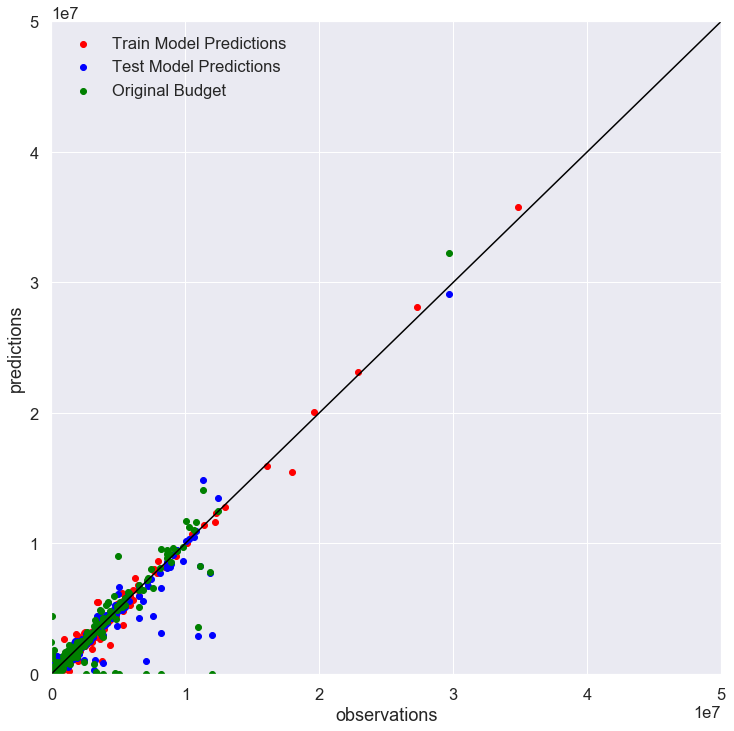

In [117]:
# fig, ax = plt.subplots(nrows=2,ncols=3)
# fig.set_size_inches(16,12)
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

x = np.linspace(-100000000,100000000,10000)
plt.figure(figsize=(12,12))
plt.scatter(list(y_train), list(xgb_train_predictions), c='red',label="Train Model Predictions") #alpha=.95)
plt.scatter(y_test, xgb_test_predictions, c='blue', label="Test Model Predictions") #alpha=.95)
plt.scatter(y_test, y_original_budget, c='green', label="Original Budget") #alpha=.95)
plt.plot(x,x,c='black')
plt.xlim([-5,50000000])
plt.ylim([-5,50000000])
plt.xlabel('observations')
plt.ylabel('predictions')
plt.title("")
plt.legend()


#fig.tight_layout()

Text(0.5, 1.0, '2012-2014 to predict 2015 Residuals')

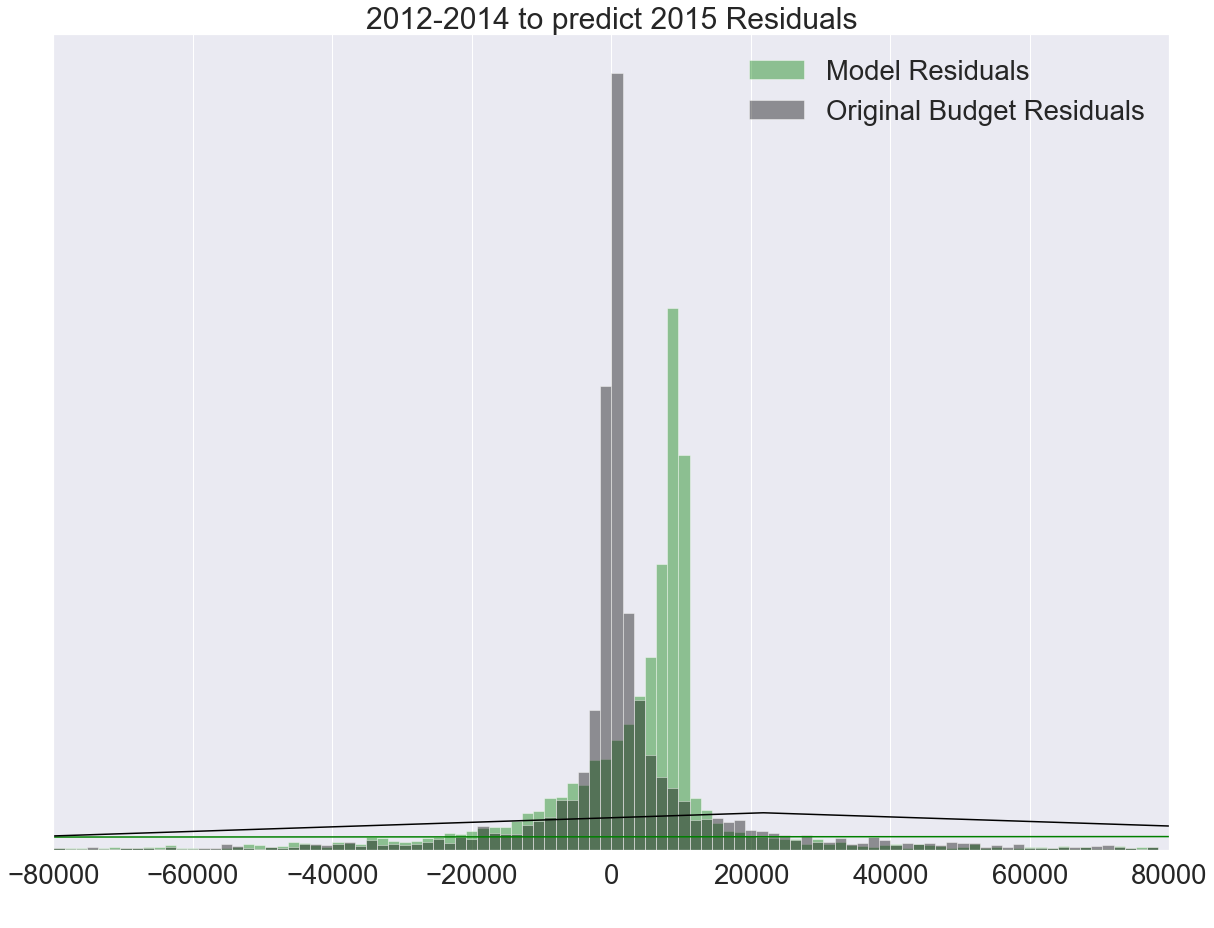

In [67]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(-80000,80000,80000/50)

sns.distplot(model_residuals, label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(original_budget_residuals, label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(-80000,80000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals")

In [104]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
yt = mr = pd.DataFrame(pd.Series(y_test))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
yt = pd.DataFrame(yt[0].values)
ob_greater_80K = ob.loc[(ob[0]>80000) | (ob[0]<-80000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>80000) | (mr[0]<-80000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]
yt_greater_80K = yt.loc[(yt[0]>80000) | (yt[0]<-80000)][0]



In [99]:
ob_less_neg_80K[:10]

NameError: name 'ob_less_neg_80K' is not defined

In [105]:
abs(ob_greater_80K)[:10]

52     874755.258413
96     158360.162547
108    173962.309812
120    153431.440209
150    207368.901357
151     90774.850010
156    488416.974823
204     93568.970772
226    128667.063622
254     92645.029123
Name: 0, dtype: float64

In [101]:
abs(mr_greater_80K[:10])

49     183606.123914
95      89468.641808
96      88284.716827
100    116423.344922
102    201235.881033
103    198346.895420
120    229066.419854
128    216344.704447
137     98133.026427
149    102455.027555
Name: 0, dtype: float64

Text(0.5, 1.0, '2012-2014 to predict 2015 Residuals Over 80K')

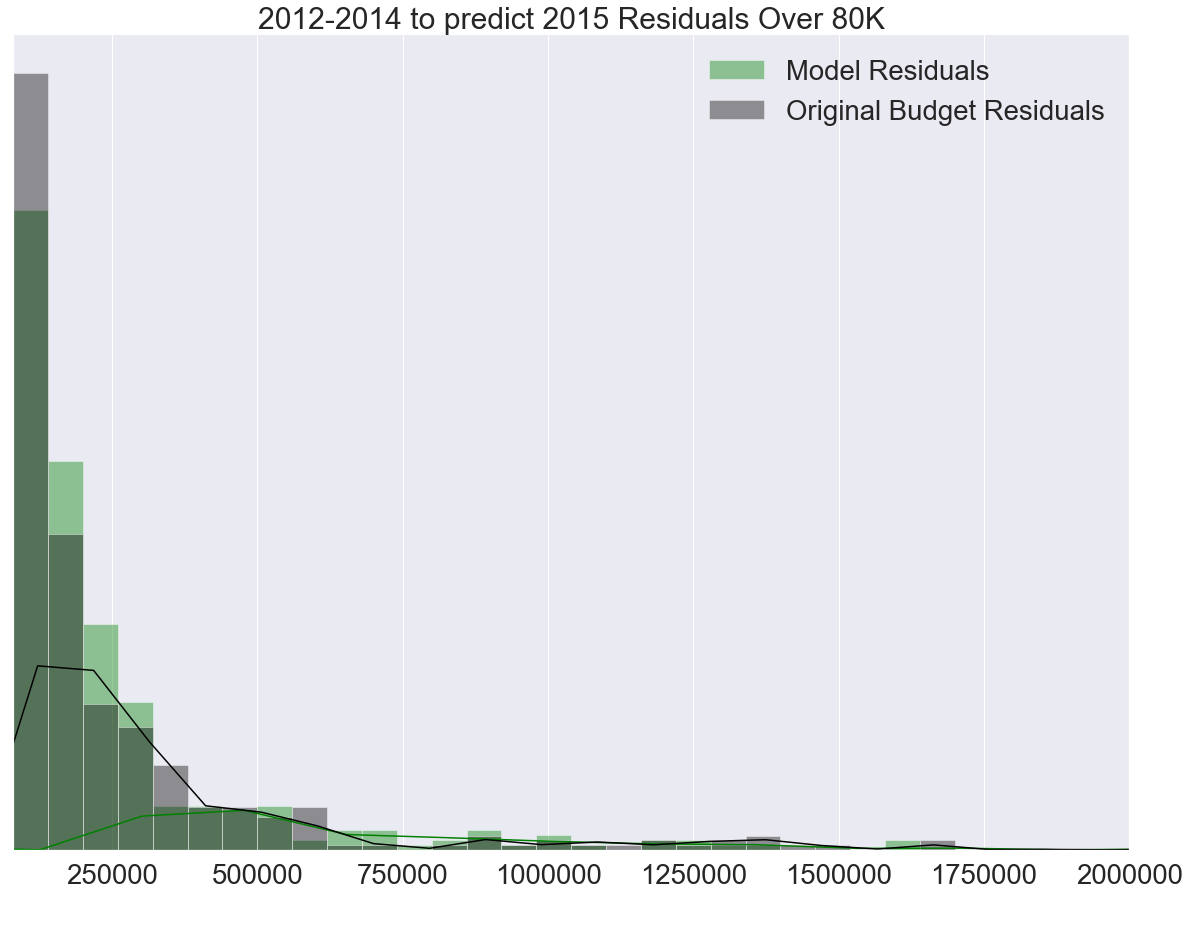

In [108]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(80000,3000000,3000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(80000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 80K")

In [109]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>200000) | (ob[0]<-200000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>200000) | (mr[0]<-200000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]


Text(0.5, 1.0, '2012-2014 to predict 2015 Residuals Over 200K')

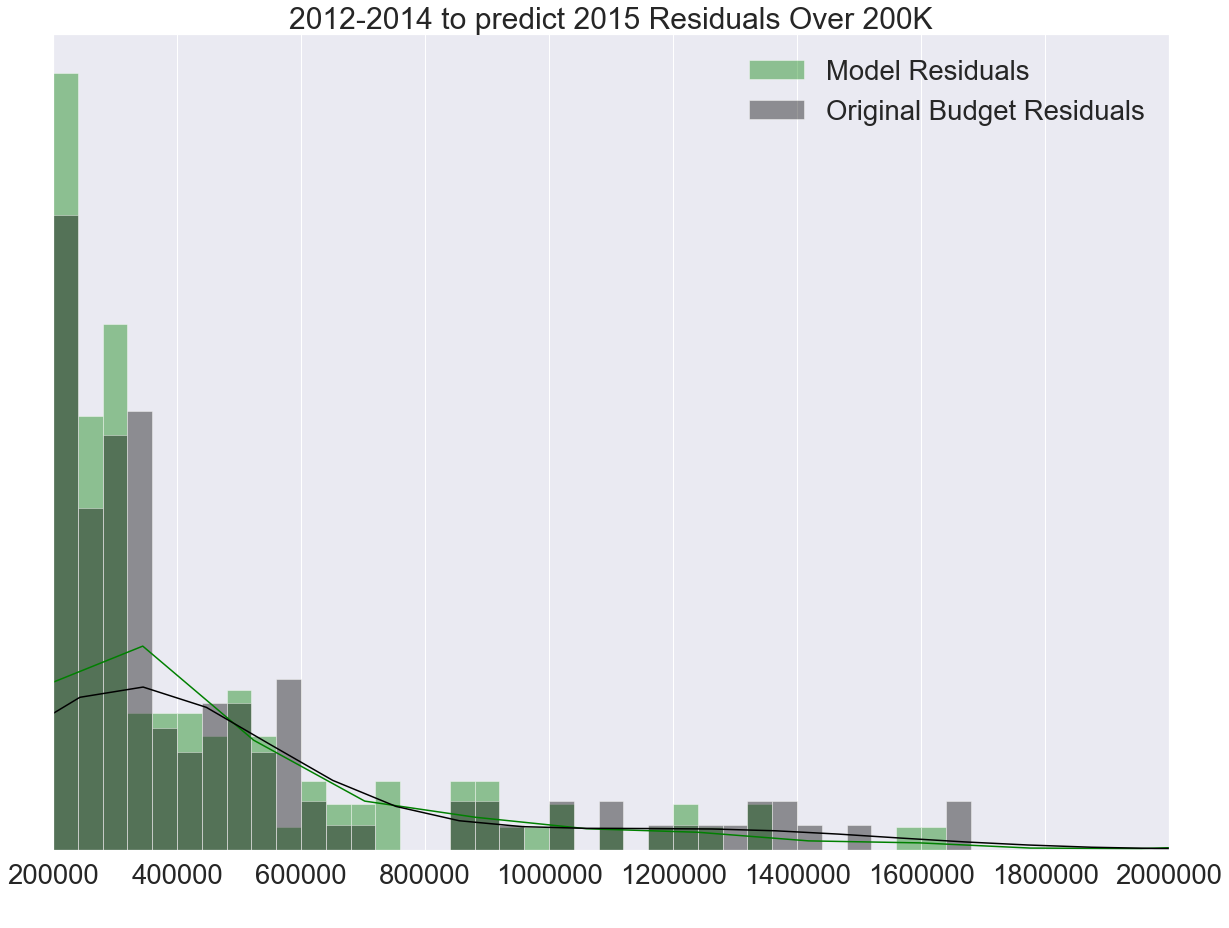

In [112]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(200000,2000000,2000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(200000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 200K")

In [114]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>2000000) | (ob[0]<-2000000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>2000000) | (mr[0]<-2000000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]

Text(0.5, 1.0, '2012-2014 to predict 2015 Residuals Over 2M')

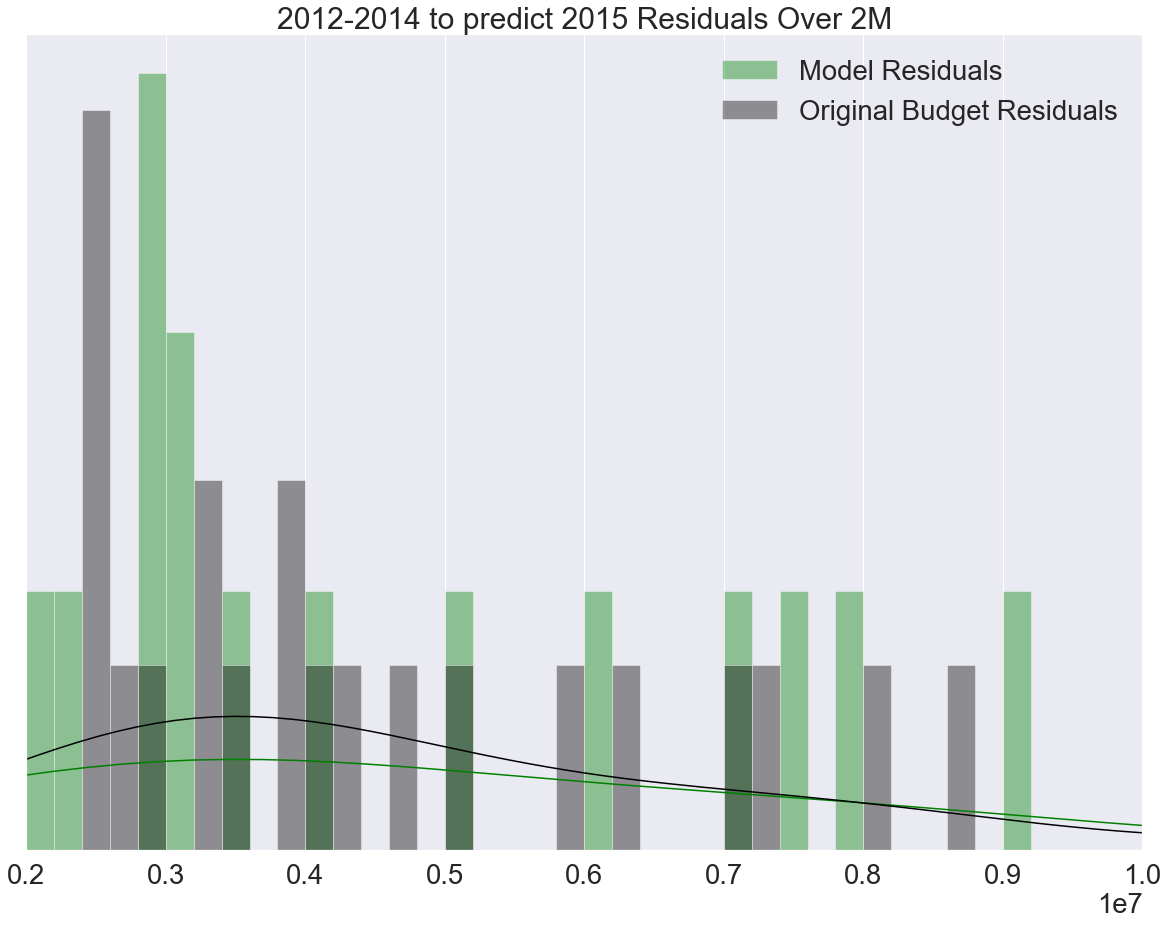

In [115]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(2000000,10000000,10000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(2000000,10000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 2M")

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


Text(0.5, 1.0, '2012-2014 to predict 2015 Residuals')

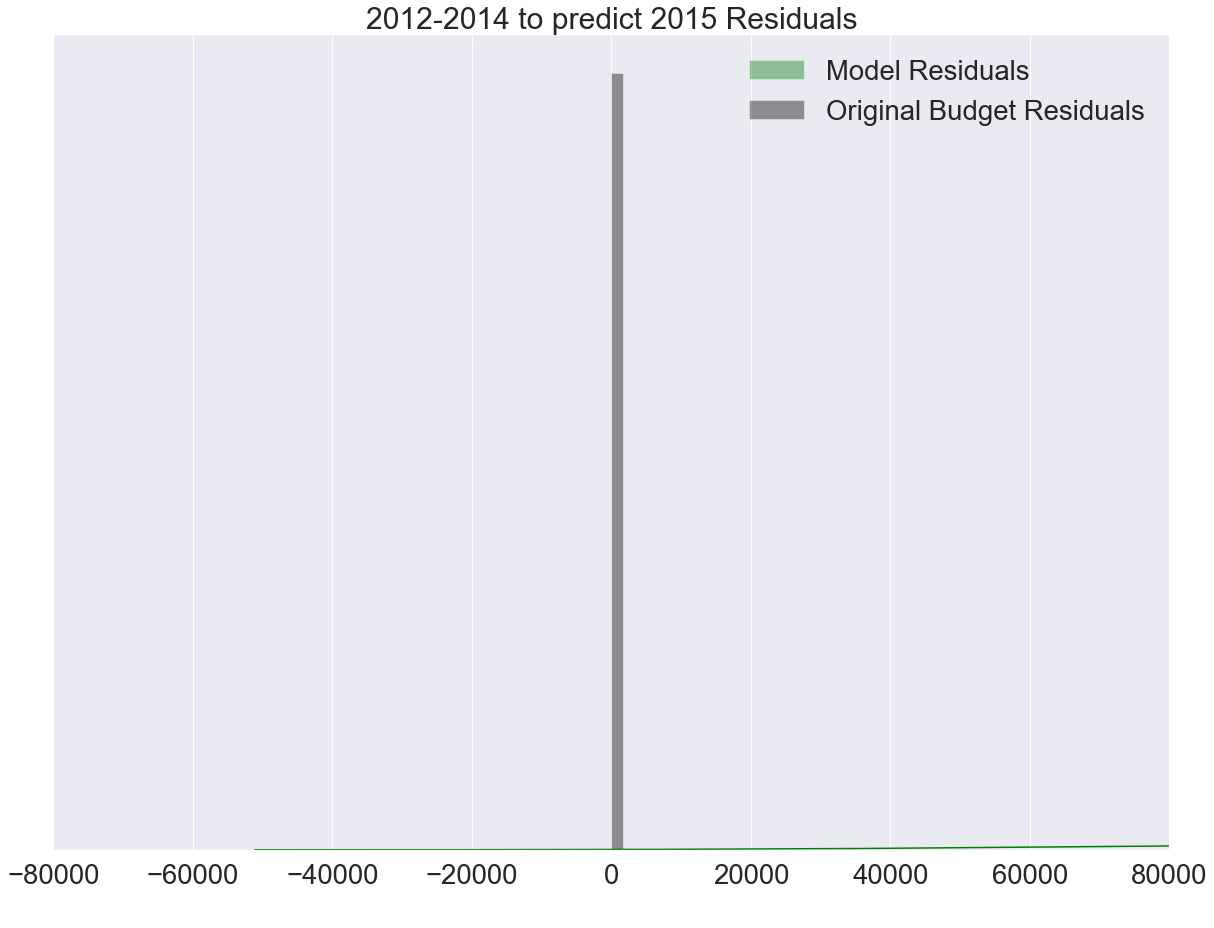

In [45]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(-80000,80000,80000/50)

sns.distplot(model_residuals, label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(original_budget_residuals, label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(-80000,80000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals")

# 2013-2015 to predict 2016

In [123]:
splits_to_try = [
    
                #predicting off "two years"
                 #[(0,1),(1,2),'10-11 to predict 11'],
                 #[(0,2),(2,3),'10-11 to predict 12'],
                 #[(0,3),(3,4),'10-12 to predict 13'],
                 #[(0,3),(3,5),'10-12 to predict 13 and 14'],
                 #[(2,4),(4,5),'12-13 to predict 14'],
                 #[(1,4),(4,5),'11-13 to predict 14'], 
                 #[(1,4),(4,6),'11-13 to predict 14 and 15'],
                 #[(3,5),(5,6),'13-14 to predict 15'],
                 #[(2,5),(5,6),'12-14 to predict 15'],
                 #[(2,5),(5,7),'12-14 to predict 15 and 16'],
                 #[(4,6),(6,7),'14-15 to predict 16'],
                 [(3,6),(6,7),'13-15 to predict 16'], 
    
                #predicting off "three" years
    
                 #[(0,4),(5,6),'10-13 to predict 14'],
                 #[(0,4),(4,6),'10-13 to predict 14 and 15'],
                 #[(0,4),(4,7),'10-13 to predict 14 and 15 and 16'],
                 #[(1,5),(5,6),'11-14 to predict 15'],
                 #[(1,5),(5,7),'11-14 to predict 15 and 16'],
                 #[(2,6),(6,7),'12-15 to predict 16']
                ]

In [124]:
hold_list = []
weight_df_list = []
for split in splits_to_try:
    
    hold_dict = {}
    
    X_train = pd.concat([x for x in fy_list[split[0][0]:split[0][1]]])
    y_train = X_train['Actuals']
    X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)
    X_test = pd.concat([x for x in fy_list[split[1][0]:split[1][1]]])
    y_test = X_test['Actuals']
    y_original_budget = X_test['Original Budget']
    X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

    model = xgb.XGBRegressor(subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, seed=1001, colsample_bytree= 1.0)
    model.fit(X_train,y_train)

    xgb_test_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)

    model_test_RMSE = np.sqrt(np.mean((xgb_test_predictions-y_test)**2))
    model_train_RMSE = np.sqrt(np.mean((xgb_train_predictions-y_train)**2))
    original_budget_RMSE = np.sqrt(np.mean((y_original_budget-y_test)**2))
    
    weight_dict = model.get_booster().get_score(importance_type="weight")
    weight_df = pd.DataFrame(weight_dict, index=range(len(weight_dict)))
    weight_df = weight_df.T[0].sort_values(ascending=False)
    
    weight_df_list.append(weight_df)

    hold_dict.update({'split': split[2]})
    hold_dict.update({'model_test_RMSE': model_test_RMSE})
    hold_dict.update({'model_train_RMSE': model_train_RMSE})
    hold_dict.update({'original_budget_RMSE': original_budget_RMSE})
    hold_dict.update({'test_predictions': xgb_test_predictions})
    hold_dict.update({'train_predictions' : xgb_train_predictions})
    hold_dict.update({'y_test' : y_test})
    hold_dict.update({'y_train' : y_train})
    hold_dict.update({'original_budget' : y_original_budget})
    hold_list.append(hold_dict)
    
   
results_df = pd.DataFrame(hold_list)
results_df['Model Improvement'] = results_df['original_budget_RMSE']-results_df['model_test_RMSE']
results_df



/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[04:48:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,model_test_RMSE,model_train_RMSE,original_budget,original_budget_RMSE,split,test_predictions,train_predictions,y_test,y_train,Model Improvement
0,513418.275562,138841.689364,0 306531.0 1 0.0 2 ...,526290.141141,13-15 to predict 16,"[272833.97, 13636.779, 10499.155, 79865.19, 37...","[156655.39, 64668.113, 10499.155, 111261.06, 3...",0 2.670169e+05 1 0.000000e+00 2 ...,0 1.535889e+05 1 0.000000e+00 2 ...,12871.86558


In [127]:
weight_df.index = ['Original Budget', '1Y_Past_Actuals', '1Y_Past_OA_Difference',
       '3Y_Past_Actuals', 'Line Item', '3Y_Past_OA_Difference',
       '2Y_1Y_OA_Difference_Mean', '2Y_Past_Actuals', '2Y_Past_OA_Difference',
       '2Y_1Y_Actuals_Mean', '3Y_Past_Original_Budget', 'GL Account',
       'Fund Id', 'Business Area', '1Y_Past_Original_Budget',
       'City Council District A_B Stardig', 'Controller_C Brown',
       'Over_Budget_Prediction',
       'Fund Name_PWE-Combined Utility System Oper Fund',
       '2Y_1Y_Original_Budget_Mean', '2Y_Past_Original_Budget',
       'Business Area Name_Houston Fire Department (HFD)',
       '1YP_OA_Diff_Over_80K', 'Fund Center Id',
       'Business Area Name_General Debt Services']

In [128]:
weight_df

Original Budget                                     237
1Y_Past_Actuals                                     109
1Y_Past_OA_Difference                                54
3Y_Past_Actuals                                      52
Line Item                                            45
3Y_Past_OA_Difference                                40
2Y_1Y_OA_Difference_Mean                             30
2Y_Past_Actuals                                      29
2Y_Past_OA_Difference                                27
2Y_1Y_Actuals_Mean                                   16
3Y_Past_Original_Budget                              16
GL Account                                           15
Fund Id                                              14
Business Area                                        12
1Y_Past_Original_Budget                              11
City Council District A_B Stardig                    10
Controller_C Brown                                    9
Over_Budget_Prediction                          

In [129]:

y_train = downsample(y_train.values, int(len(y_train.values)/5))
y_test = downsample(y_test.values, int(len(y_test)/2))
xgb_test_predictions = downsample(xgb_test_predictions, int(len(xgb_test_predictions)/2))
xgb_train_predictions = downsample(xgb_train_predictions, int(len(xgb_train_predictions)/5))
y_original_budget = downsample(y_original_budget.values, int(len(y_original_budget.values)/2))
# split = results_df.iloc[0]['split']



In [130]:
original_budget_residuals = y_original_budget-y_test
model_residuals = xgb_test_predictions-y_test

In [131]:
model_residuals_series = pd.Series(model_residuals)
original_budget_residuals_series =pd.Series(original_budget_residuals)

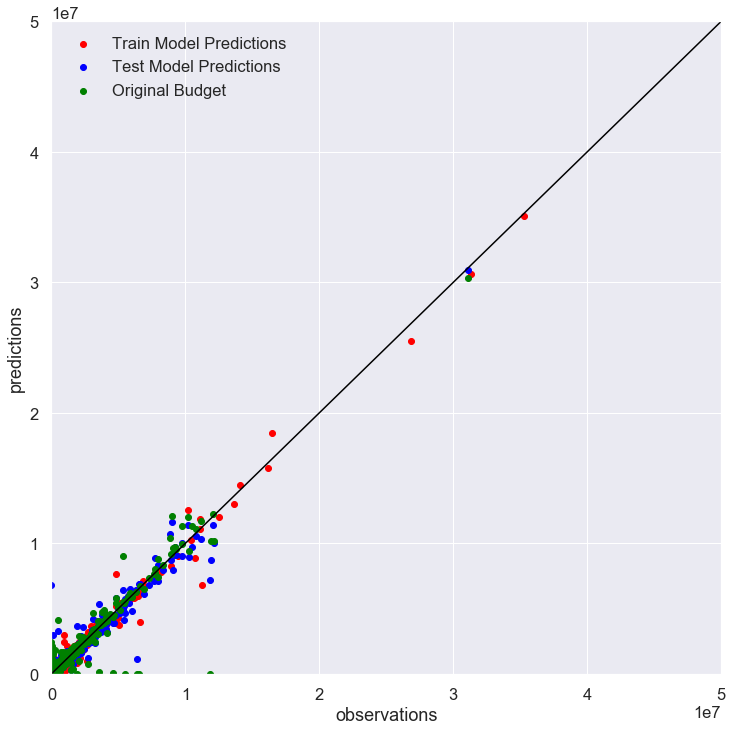

In [132]:
# fig, ax = plt.subplots(nrows=2,ncols=3)
# fig.set_size_inches(16,12)
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

x = np.linspace(-100000000,100000000,10000)
plt.figure(figsize=(12,12))
plt.scatter(list(y_train), list(xgb_train_predictions), c='red',label="Train Model Predictions") #alpha=.95)
plt.scatter(y_test, xgb_test_predictions, c='blue', label="Test Model Predictions") #alpha=.95)
plt.scatter(y_test, y_original_budget, c='green', label="Original Budget") #alpha=.95)
plt.plot(x,x,c='black')
plt.xlim([-5,50000000])
plt.ylim([-5,50000000])
plt.xlabel('observations')
plt.ylabel('predictions')
plt.title("")
plt.legend()


#fig.tight_layout()

Text(0.5, 1.0, '2013-2015 to predict 2016 Residuals')

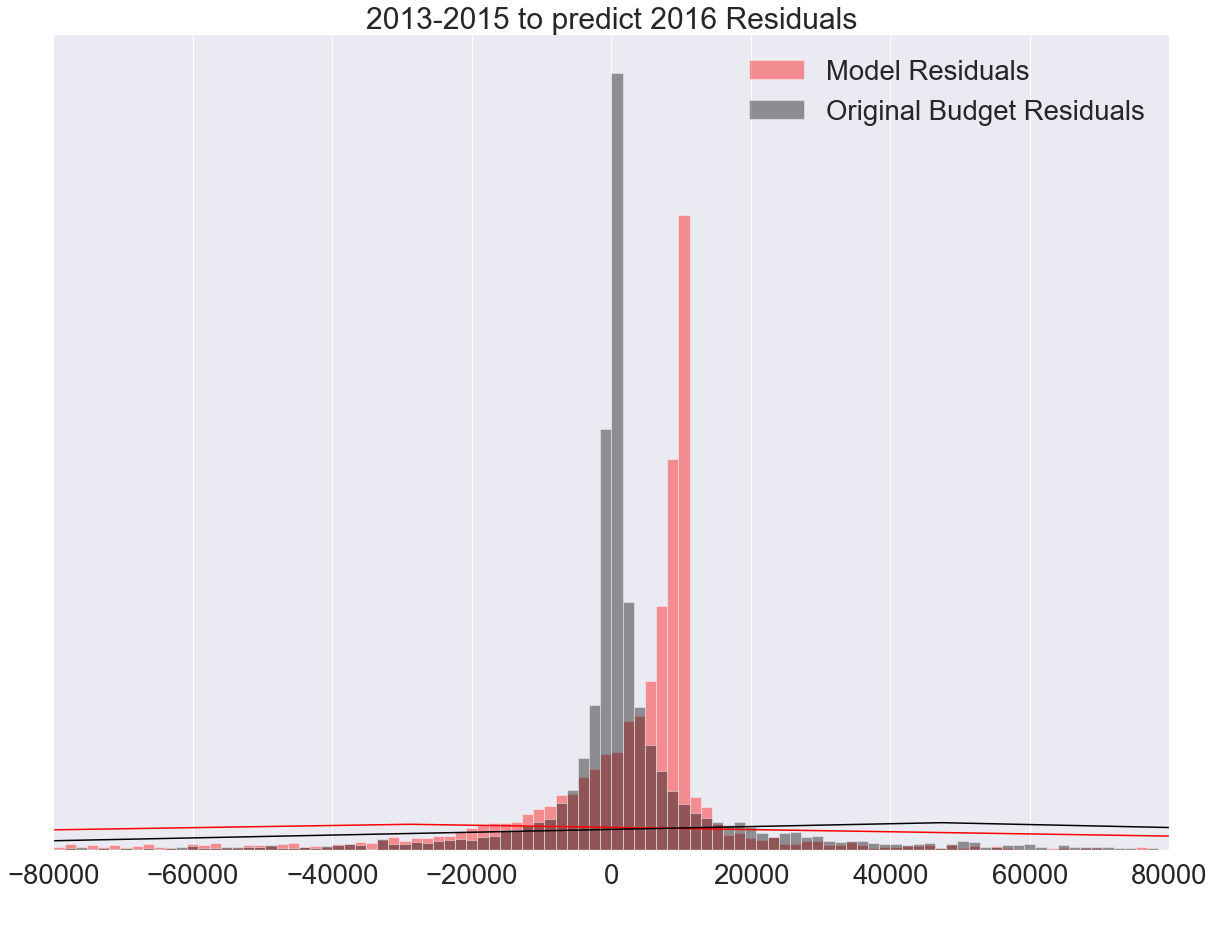

In [140]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(-80000,80000,80000/50)

sns.distplot(model_residuals, label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(original_budget_residuals, label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(-80000,80000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals")


In [141]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
yt = mr = pd.DataFrame(pd.Series(y_test))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
yt = pd.DataFrame(yt[0].values)
ob_greater_80K = ob.loc[(ob[0]>80000) | (ob[0]<-80000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>80000) | (mr[0]<-80000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]
yt_greater_80K = yt.loc[(yt[0]>80000) | (yt[0]<-80000)][0]



Text(0.5, 1.0, '2013-2015 to predict 2016 Residuals Over 80K')

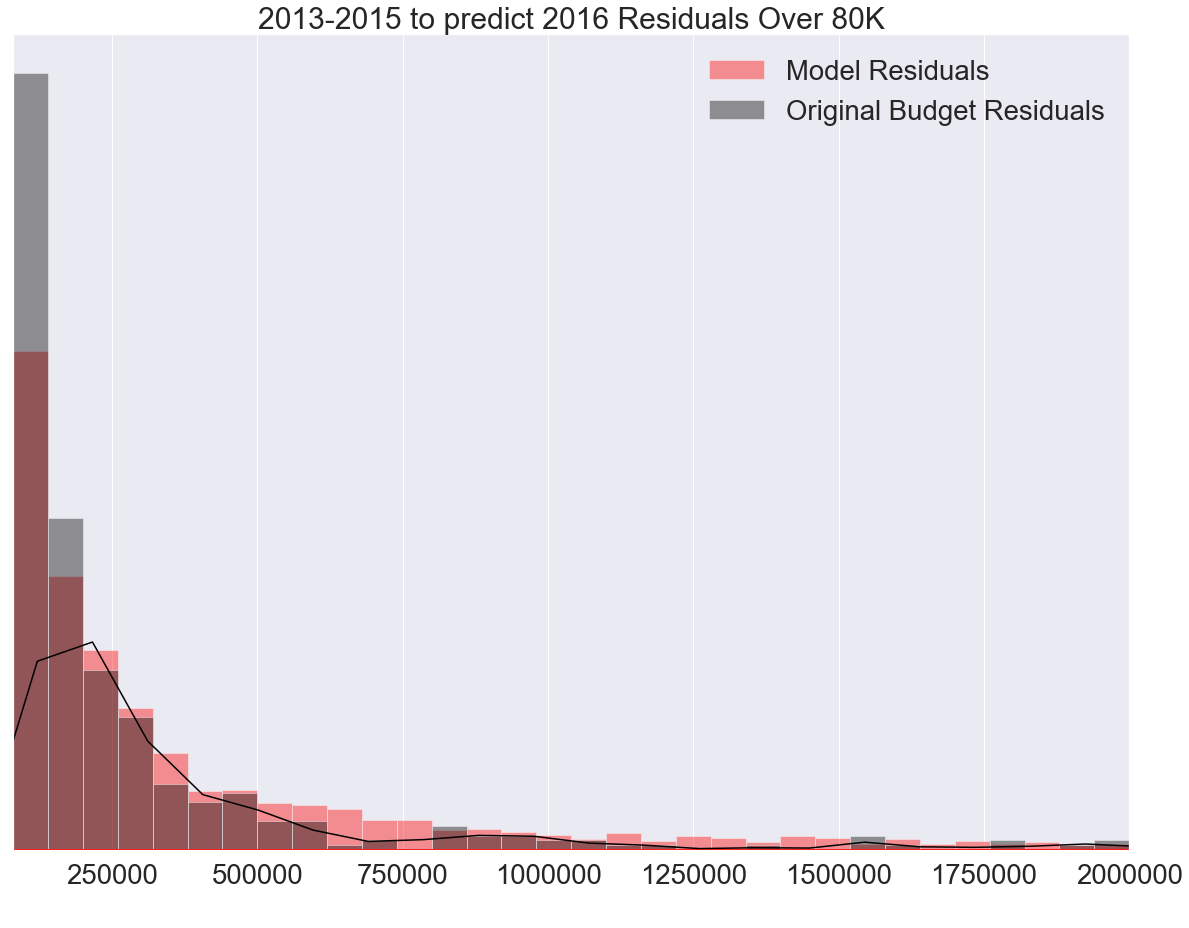

In [142]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(80000,3000000,3000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(80000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals Over 80K")

In [143]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>200000) | (ob[0]<-200000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>200000) | (mr[0]<-200000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]


In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(2000000,10000000,10000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(2000000,10000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 2M")

Text(0.5, 1.0, '2012-2014 to predict 2015 Residuals Over 200K')

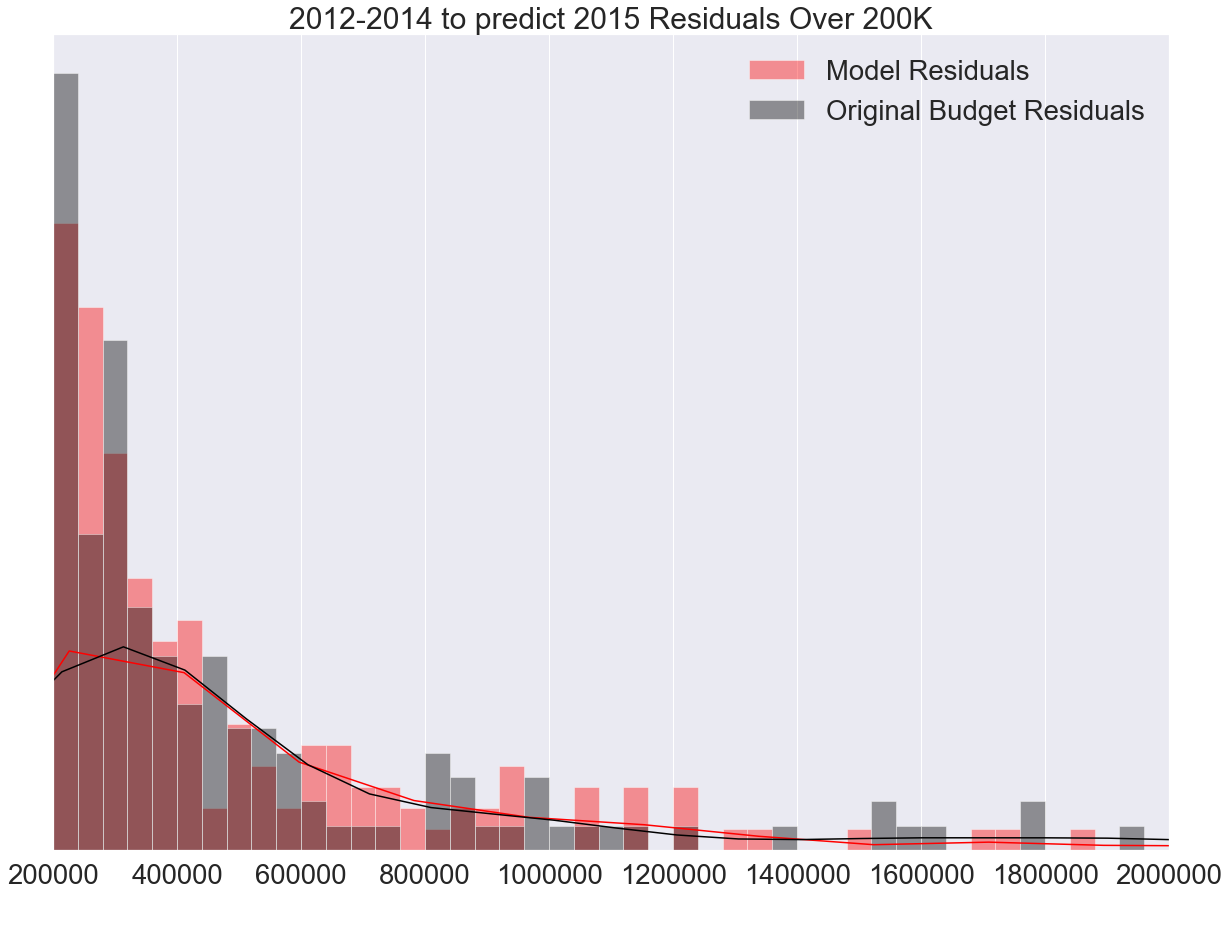

In [144]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(200000,2000000,2000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(200000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 200K")

In [145]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>2000000) | (ob[0]<-2000000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>2000000) | (mr[0]<-2000000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]

Text(0.5, 1.0, '2013-2015 to predict 2016 Residuals Over 2M')

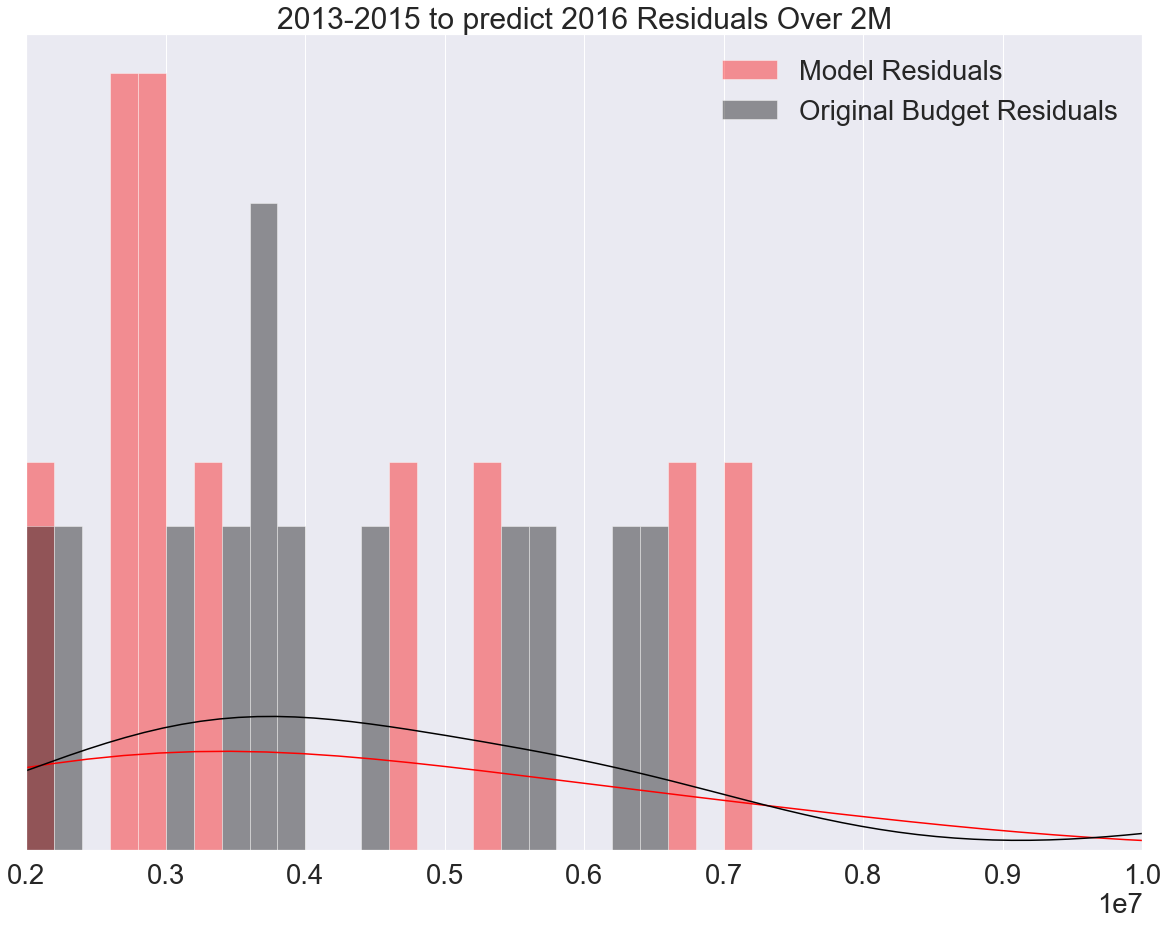

In [146]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(2000000,10000000,10000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(2000000,10000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals Over 2M")

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(-80000,80000,80000/50)

sns.distplot(model_residuals, label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(original_budget_residuals, label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(-80000,80000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals")

In [ ]:
#results_df.iloc[:,0:5].drop(['original_budget'],axis=1).to_csv("results_df.csv")

In [ ]:

#downsampled =  signal.resample(y, 6000)

In [ ]:
# for index, row in results_df.iterrows():
#     xgb_test_predictions = row['test_predictions']
#     y_test = row['y_test']
#     y_original_budget = row['original_budget']
#     results_df.loc[index, 'Model Sum Error'] = int(np.sum(abs(xgb_test_predictions-y_test)))
#     results_df.loc[index, 'Budget Sum Error'] = int(np.sum(abs(y_original_budget-y_test)))
#     results_df.loc[index, 'Model Increased Precision'] = int(results_df.loc[index, 'Budget Sum Error']-results_df.loc[index, 'Model Sum Error'])
    
    

In [ ]:
results_df

In [ ]:
from scipy.interpolate import interp1d

def downsample(array, npts):
    interpolated = interp1d(np.arange(len(array)), array, axis = 0, fill_value = 'extrapolate')
    downsampled = interpolated(np.linspace(0, len(array), npts))
    return downsampled

#https://stackoverflow.com/questions/53307107/how-do-i-downsample-a-1d-numpy-array

In [ ]:
index=0
hold_df1214_15_test = pd.DataFrame()
hold_df1214_15_train = pd.DataFrame()
hold_df1214_15_test['test_predictions'] = results_df.iloc[index]['test_predictions']
hold_df1214_15_train['train_predictions'] = results_df.iloc[index]['test_predictions']
hold_df1214_15_test['y_test'] = results_df.iloc[index]['y_test'].values
hold_df1214_15_train['y_train'] = results_df.iloc[index]['y_train'].values
hold_df1214_15_test['original_budget'] = results_df.iloc[index]['original_budget'].values


In [ ]:
index=1
hold_df1315_17 = pd.DataFrame()
hold_df1315_17['test_predictions'] = results_df.iloc[index]['test_predictions']
hold_df1315_17['train_predictions'] = results_df.iloc[index]['test_predictions']
hold_df1315_17['y_test'] = results_df.iloc[index]['y_test']
hold_df1315_17['y_train'] = results_df.iloc[index]['y_train']
hold_df1315_17['original_budget'] = results_df.iloc[index]['original_budget']


In [ ]:
# fig, ax = plt.subplots(nrows=2,ncols=3)
# fig.set_size_inches(16,12)
# sns.set_style('whitegrid')
# i = 0

# for index, row in results_df.iterrows():
#     y_train = downsample(row['y_train'], int(len(row['y_train'])/5))
#     y_test = downsample(row['y_test'], int(len(row['y_test'])/5))
#     xgb_test_predictions = downsample(row['test_predictions'], int(len(row['test_predictions'])/5))
#     xgb_train_predictions = downsample(row['train_predictions'], int(len(row['train_predictions'])/5))
#     y_original_budget = downsample(row['original_budget'], int(len(row['original_budget'])/5))
#     split = row['split']
    
#     x = np.linspace(-1000000000,1000000000,1000000000)
#     plt.figure(figsize=(12,12))
#     plt.scatter(y_train, xgb_train_predictions, c='red') #alpha=.95)
#     plt.scatter(y_test, xgb_test_predictions, c='blue') #alpha=.95)
#     plt.scatter(y_test, y_original_budget, c='green') #alpha=.95)
#     plt.plot(x,x,c='black')
#     plt.xlim([-5,1000000000])
#     plt.ylim([-5,1000000000])
#     plt.xlabel('observations')
#     plt.ylabel('predictions')
#     plt.title(split)


# fig.tight_layout()

# H2o

In [167]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 4 mins
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,1 month and 16 days
H2O cluster name:,H2O_from_python_josephdown_f2qly4
H2O cluster total nodes:,1
H2O cluster free memory:,3.842 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [168]:
fy_10 = pd.read_csv('2010_clfpred')
fy_11 = pd.read_csv('2011_clfpred')
fy_12 = pd.read_csv('2012_clfpred')
fy_13 = pd.read_csv('2013_clfpred')
fy_14 = pd.read_csv('2014_clfpred')
fy_15 = pd.read_csv('2015_clfpred')
fy_16 = pd.read_csv('2016_clfpred')

fy_list = [fy_10, fy_11, fy_12, fy_13, fy_14, fy_15, fy_16]

del fy_10
del fy_11
del fy_12
del fy_13
del fy_14
del fy_15
del fy_16
gc.collect()


11692

In [163]:
# fy_list[5]['Actuals'] = pd.read_csv('2015_clfpred')['Actuals']
# y_original_budget = pd.read_csv('2015_clfpred')['Original Budget']

In [170]:
X_train = pd.concat([x for x in fy_list[3:5]])
y_train = X_train['Actuals']
X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

X_test = fy_list[5]
y_test = fy_list[5]['Actuals']
y_original_budget = X_test['Original Budget']
X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)



In [171]:
# create h2o frame for training data
training_frame = pd.concat([X_train,y_train], axis=1)
training_frame.columns = list(training_frame.columns[:-1]) + ['Actuals']
training_frame = h2o.H2OFrame(training_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [172]:
# create h2o frame for testing data
testing_frame = pd.concat([X_test,y_test], axis=1)
testing_frame.columns = list(testing_frame.columns[:-1]) + ['Actuals']
testing_frame = h2o.H2OFrame(testing_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(None, 'Actuals', training_frame)

AutoML progress: |██████████

### Model RMSE

In [ ]:
predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1)))
np.sqrt(np.mean((predicted_actuals['predict'].as_data_frame()['predict'].values-y_test)**2))


### Budget RMSE

In [ ]:
predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1)))
np.sqrt(np.mean((y_original_budget-y_test)**2))

In [ ]:
train_predicted_actuls = aml.predict(h2o.H2OFrame(pd.concat([X_train, y_train], axis=1)))

In [ ]:
aml.leader

In [ ]:
y_train = downsample(y_train.values, int(len(y_train.values)/5))
y_test = downsample(y_test.values, int(len(y_test)/2))
predicted_actuals = downsample(predicted_actuals, int(len(predicted_actuals)/2))
train_predicted_actuls = downsample(train_predicted_actuls, int(len(train_predicted_actuls)/5))
y_original_budget = downsample(y_original_budget.values, int(len(y_original_budget.values)/2))


In [ ]:
### Being a bad coder here and or lazy

In [ ]:
xgb_test_predictions = predicted_actuals
xgb_train_predictions = train_predicted_actuals

In [ ]:
original_budget_residuals = y_original_budget-y_test
model_residuals = xgb_test_predictions-y_test

In [ ]:
model_residuals_series = pd.Series(model_residuals)
original_budget_residuals_series =pd.Series(original_budget_residuals)

# Plotting H2O 2015

In [ ]:
# fig, ax = plt.subplots(nrows=2,ncols=3)
# fig.set_size_inches(16,12)
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

x = np.linspace(-100000000,100000000,10000)
plt.figure(figsize=(12,12))
plt.scatter(list(y_train), list(xgb_train_predictions), c='red',label="Train Model Predictions") #alpha=.95)
plt.scatter(y_test, xgb_test_predictions, c='blue', label="Test Model Predictions") #alpha=.95)
plt.scatter(y_test, y_original_budget, c='green', label="Original Budget") #alpha=.95)
plt.plot(x,x,c='black')
plt.xlim([-5,50000000])
plt.ylim([-5,50000000])
plt.xlabel('observations')
plt.ylabel('predictions')
plt.title("")
plt.legend()


#fig.tight_layout()

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(-80000,80000,80000/50)

sns.distplot(model_residuals, label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(original_budget_residuals, label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(-80000,80000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals")


In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
yt = mr = pd.DataFrame(pd.Series(y_test))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
yt = pd.DataFrame(yt[0].values)
ob_greater_80K = ob.loc[(ob[0]>80000) | (ob[0]<-80000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>80000) | (mr[0]<-80000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]
yt_greater_80K = yt.loc[(yt[0]>80000) | (yt[0]<-80000)][0]



In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(80000,3000000,3000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(80000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 80K")

In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>200000) | (ob[0]<-200000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>200000) | (mr[0]<-200000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]


In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(200000,2000000,2000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(200000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 200K")

In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>2000000) | (ob[0]<-2000000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>2000000) | (mr[0]<-2000000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(2000000,10000000,10000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(2000000,10000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 2M")

# H20 Predicting 2016

In [ ]:
X_train = pd.concat([x for x in fy_list[4:6]])
y_train = X_train['Actuals']
X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

X_test = fy_list[6]
y_test = X_test['Actuals']
y_original_budget = X_test['Original Budget']
X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)



In [ ]:
# create h2o frame for training data
training_frame = pd.concat([X_train,y_train], axis=1)
training_frame.columns = list(training_frame.columns[:-1]) + ['Actuals']
training_frame = h2o.H2OFrame(training_frame)

In [ ]:
# create h2o frame for testing data
testing_frame = pd.concat([X_test,y_test], axis=1)
testing_frame.columns = list(testing_frame.columns[:-1]) + ['Actuals']
testing_frame = h2o.H2OFrame(testing_frame)

In [ ]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(None, 'Actuals', training_frame)

### Model RMSE

In [ ]:
predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1)))
np.sqrt(np.mean((predicted_actuals['predict'].as_data_frame()['predict'].values-y_test)**2))


### Budget RMSE

In [ ]:
predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1)))
np.sqrt(np.mean((y_original_budget-y_test)**2))

In [ ]:
train_predicted_actuls = aml.predict(h2o.H2OFrame(pd.concat([X_train, y_train], axis=1)))

In [ ]:
aml.leader

In [ ]:
y_train = downsample(y_train.values, int(len(y_train.values)/5))
y_test = downsample(y_test.values, int(len(y_test)/2))
predicted_actuals = downsample(predicted_actuals, int(len(predicted_actuals)/2))
train_predicted_actuls = downsample(train_predicted_actuls, int(len(train_predicted_actuls)/5))
y_original_budget = downsample(y_original_budget.values, int(len(y_original_budget.values)/2))


In [ ]:
### Being a bad coder here and or lazy

In [ ]:
xgb_test_predictions = predicted_actuals
xgb_train_predictions = train_predicted_actuals

In [ ]:
original_budget_residuals = y_original_budget-y_test
model_residuals = xgb_test_predictions-y_test

In [ ]:
model_residuals_series = pd.Series(model_residuals)
original_budget_residuals_series =pd.Series(original_budget_residuals)

# Plotting H2O 2016

In [ ]:
# fig, ax = plt.subplots(nrows=2,ncols=3)
# fig.set_size_inches(16,12)
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

x = np.linspace(-100000000,100000000,10000)
plt.figure(figsize=(12,12))
plt.scatter(list(y_train), list(xgb_train_predictions), c='red',label="Train Model Predictions") #alpha=.95)
plt.scatter(y_test, xgb_test_predictions, c='blue', label="Test Model Predictions") #alpha=.95)
plt.scatter(y_test, y_original_budget, c='green', label="Original Budget") #alpha=.95)
plt.plot(x,x,c='black')
plt.xlim([-5,50000000])
plt.ylim([-5,50000000])
plt.xlabel('observations')
plt.ylabel('predictions')
plt.title("")
plt.legend()


#fig.tight_layout()

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(-80000,80000,80000/50)

sns.distplot(model_residuals, label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(original_budget_residuals, label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(-80000,80000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals")


In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
yt = mr = pd.DataFrame(pd.Series(y_test))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
yt = pd.DataFrame(yt[0].values)
ob_greater_80K = ob.loc[(ob[0]>80000) | (ob[0]<-80000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>80000) | (mr[0]<-80000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]
yt_greater_80K = yt.loc[(yt[0]>80000) | (yt[0]<-80000)][0]



In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(80000,3000000,3000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(80000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals Over 80K")

In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>200000) | (ob[0]<-200000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>200000) | (mr[0]<-200000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]


In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(200000,2000000,2000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(200000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals Over 200K")

In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>2000000) | (ob[0]<-2000000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>2000000) | (mr[0]<-2000000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(2000000,10000000,10000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(2000000,10000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals Over 2M")